# Filtracja Non-Local Means

## Definicja

Kolejny "poziom wtajemniczenia" w zagadnienie filtracji obrazów to metoda Non-Local Means (NLM).
Została ona zaproponowana w pracy *"A non-local algorithm for image denoising"* (autorzy: Antoni Buades, Bartomeu Coll i Jean Michel Morel) na konferencji CVPR w 2005 roku.

Filtr NLM dany jest zależnością:

\begin{equation}
\hat{I}(\mathbf{x}) = \sum_{\mathbf{p} \in V(\mathbf{x})} w(\mathbf{p},\mathbf{x})I(\mathbf{p})
\tag{1}
\end{equation}

gdzie:
- $I$ - obraz wejściowy,
- $\hat{I}$ - obraz wyjściowy (przefiltrowany),
- $\mathbf{x}$ - współrzędne piksela obrazu,
- $V(\mathbf{x})$ - obszar poszukiwań piksela, dla którego przeprowadzana jest filtracja,
- $w$ - waga punktu $\mathbf{p}$ z obszaru poszukiwań.

Wróćmy na chwilę do filtracji bilateralnej. Tam waga danego piksela z kontekstu zależała od dwóch czynników - odległości przestrzennej pomiędzy pikselami oraz różnicy w jasności/kolorze pomiędzy pikselami (tzw. przeciwdziedzina).
Filtr NLM stanowi uogólnienie tej metody - do obliczania wag nie wykorzystuje się już pojedynczych pikseli ($\mathbf{p}$ i $\mathbf{x}$), a lokalne konteksty ($N(\mathbf{p})$ i $N(\mathbf{x})$).

Waga $w$ dana jest następującą zależnością:

\begin{equation}
w(\mathbf{p},\mathbf{x}) = \frac{1}{Z(\mathbf{x})}\exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\tag{2}
\end{equation}

gdzie:
\begin{equation}
Z(\mathbf{x}) = \sum_{\mathbf{p} \in V(\mathbf{x})} \exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\tag{3}
\end{equation}

- $|| \cdot ||$ - jest normą $L_2$ odległości pomiędzy dwoma kontekstami,
- $v$ oznacza mnożenie punktowe kontekstu $N$ przez dwuwymiarową maskę Gaussa o odpowiadających kontekstowi wymiarach,
- $\alpha$ > 0 - parametr sterujący filtracją,
- $\sigma$ - parametr szumu stacjonarnego występującego na obrazie (w przypadku szumu niestacjonarnego, parametr $\sigma$ musi zostać dopasowany lokalnie tj. $\sigma = \sigma(\mathbf{x})$).

## Analiza działania

Zastanówmy sie teraz jak działa filtra NLM. Najprościej to zrozumieć na rysunku.

![Ilustracja NLM](https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/nlm.png)

1. Dla rozważanego piksela $\mathbf{x}$ definiujemy obszar poszukiwań $V(\mathbf{x})$. Uwaga - obszar poszukiwań ($V$) jest jednostką większą niż otocznie/kontekst ($N$).

2. Następnie, dla każdego z pikseli $\mathbf{p} \in  V(\mathbf{x})$ oraz samego $\mathbf{x}$ definiujemy otocznie/kontekst odpowiednio $N(\mathbf{p})$ i $N(\mathbf{x})$.

3. Wracamy do równania definiującego wagę  $w(\mathbf{p},\mathbf{x})$, a konkretnie do wyrażenia $|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||$. Przeanalizujmy co ono oznacza. Mamy dwa otoczenia: $N(\mathbf{p})$ i $N(\mathbf{x})$. Każde z nich mnożymy przez odpowiadającą maskę Gaussa - funkcja $v$. Otrzymujemy dwie macierze, które odejmujemy od siebie punktowo. Następnie obliczamy kwadrat z normy ($L_2$ definiujemy jako $||X||_2 = \sqrt{\sum_k|X_k|^2}$. Otrzymujemy zatem jedną liczbę, która opisuje nam podobieństwo otoczeń pikseli $\mathbf{x}$ i $\mathbf{p}$. Mała wartość oznacza otoczenia zbliżone, duża - różniące się. Ponieważ, z dokładnością do stałych, liczba ta stanowi wykładnik funkcji $e^{-x}$, to ostatecznie waga jest zbliżona do 1 dla otoczeń podobnych, a szybko maleje wraz z malejącym podobieństwem kontekstów.

4. Podsumowując: jak wynika z powyższej analizy filtr NLM to taki filtr bilateralny, w którym zamiast pojedynczych pikseli porównuje się ich lokalne otoczenia. Wpływa to pozytywnie na jakość filtracji, niestety kosztem złożoności obliczeniowej.

## Implementacja

W ramach zadania należy zaimplementować filtr NLM, ocenić jego działanie w porównaniu do filtra Gaussa i bilateralnego oraz dokonać pomiaru czasu obliczeń (dla trzech wymienionych metod).

Jak już się zrozumie jak działa NLM, jego implementacja jest dość prosta.
Wartość parametru $\alpha$ należy dobrać eksperymentalnie.
Nie należy także "przesadzić" z rozmiarem obszaru poszukiwań (np. 11x11) oraz kontekstu (5x5 lub 3x3).

Wskazówki do implementacji:
- algorytm sprowadza się do dwóch podwójnych pętli for: zewnętrzne po pikselach, wewnętrzne po kolejnych obszarach przeszukań,
- przed realizacją trzeba przemyśleć problem pikseli brzegowych - de facto problemów jest kilka. Po pierwsze nie dla każdego piksela można wyznaczyć pełny obszar przeszukań (tu propozycja, aby filtrację przeprowadzać tylko dla pikseli z pełnym obszarem). Po drugie, ponieważ rozpatrujemy konteksty, to nawet dla piksela o "pełnym" obszarze przeszukań, będą istnieć piksele, dla których nie pełnych kontekstów (sugestia - powiększyć obszar przeszukać, tak aby zawierał konteksty). Ostatni problem jest bardziej techniczny/implementacyjny. Jeśli w kolejnych iteracjach "jawnie" wytniemy fragment o rozmiarach obszaru przeszukiwań, to znowu pojawi się problem brzegowy - tu można albo wyciąć nieco większy obszar, albo cały czas "pracować" na obrazie oryginalnym ("żonglerka indeksami").
- warto sprawdzać indeksy i rozmiary "wycinanych" kontekstów,
- wagi wyliczamy w trzech krokach:
    - obliczenia dla $N(\mathbf{x})$ + inicjalizacja macierzy na wagi,
    - podwójna pętla, w której przeprowadzamy obliczenia dla kolejnych $N(\mathbf{p})$ oraz wyliczamy wagi,
    - normalizacja macierzy wag oraz końcowa filtracja obszaru w wykorzystaniem wag.
- uwaga, obliczenia trochę trwają, nawet dla obrazka 256x256 i względnie niewielkich obszaru przeszukań i kontesktu.

Efekt końcowy:
- porównanie wyników metod: filtr Gaussa, filtr bilateralny oraz filtr NLM (2-3 zdania komentarza),
- porównanie czasu działania powyższych metod (1 zdanie komentarza).


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
import math
import os
import time

if not os.path.exists("MR_data.mat") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat --no-check-certificate

mat = loadmat('MR_data.mat')

I0 = mat['I_noisefree']
I1 = mat['I_noisy1']
I2 = mat['I_noisy2']
I3 = mat['I_noisy3']
I4 = mat['I_noisy4']

In [2]:
def new_pixel(window,f):
    value = 0
    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            value += window[i,j]*f[i,j]
    return value

def gauss_filter(image,size,var):
    f = np.zeros((size,size))
    C = 1.0 / (2.0*np.pi*var*var)
    for i in range(size):
        for j in range(size):
            x = i - size//2
            y = j - size//2
            res = np.sqrt(x**2+y**2)
            f[i,j] = C*np.exp(-(res**2)/(2.0*var*var))
    IConv = image.copy()
    for i in range(size//2,image.shape[0]-size//2):
        for j in range(size//2,image.shape[1]-size//2):
            context = image[i-size//2:i+size//2+1,j-size//2:j+size//2+1]
            IConv[i,j] = new_pixel(context,f)
    return IConv

In [3]:
def new_pixel2(window,f,varR):
    value = 0
    norm = 0
    mid_pixel = window[window.shape[0]//2,window.shape[1]//2]
    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            diff = np.abs(mid_pixel-window[i,j])
            gamma = np.exp(-(diff**2)/(2*varR**2))
            value += window[i,j]*f[i,j]*gamma
            norm += gamma*f[i,j]
    return value/norm

def bilateral_filter(image,size,varS,varR):
    f = np.zeros((size,size))
    for i in range(size):
        for j in range(size):
            x = i - size//2
            y = j - size//2
            res = np.sqrt(x**2+y**2)
            f[i,j] = np.exp(-(res**2)/(2.0*varS*varS))
    IBilateral = image.copy()
    for i in range(size//2,image.shape[0]-size//2):
        for j in range(size//2,image.shape[1]-size//2):
            context = image[i-size//2:i+size//2+1,j-size//2:j+size//2+1]
            IBilateral[i,j] = new_pixel2(context,f,varR)
    return IBilateral

In [4]:
def NLM_filter(image,find_size,context_size,alfa):
    INLM = image.copy()
    var = 6
    f = np.zeros((context_size,context_size))
    for context_i in range(context_size):
        for context_j in range(context_size):
            x = context_i - context_size//2
            y = context_j - context_size//2
            res = np.sqrt(x**2+y**2)
            f[context_i,context_j] = np.exp(-(res**2)/(2.0*var*var))
    for i in range(find_size//2+context_size//2,image.shape[0]-find_size//2-context_size//2-1):
        for j in range(find_size//2+context_size//2,image.shape[1]-find_size//2-context_size//2-1):
            new_pixel = 0
            Z = 0
            find = image[i-find_size//2-context_size//2:i+find_size//2+context_size//2+1,j-find_size//2-context_size//2:j+find_size//2+context_size//2+1]
            mid_a = find.shape[0]//2-context_size//2
            mid_b = find.shape[0]//2+context_size//2+1
            mid_surrounding =  find[mid_a:mid_b,mid_a:mid_b]
            mid_surrounding = mid_surrounding*f
            for find_i in range(1,find_size+1):
                for find_j in range(1,find_size+1):
                    e1 = find_i+context_size//2+1
                    e2 = find_j+context_size//2+1
                    if find_i+context_size//2+context_size//2+1 == find.shape[0]:
                        e1 = -1
                    if find_j+context_size//2+context_size//2+1 == find.shape[0]:
                        e2 = -1
                    surrounding = find[find_i-1:e1,find_j-1:e2]
                    surrounding = surrounding*f
                    diff = np.abs(mid_surrounding-surrounding)
                    diff = np.linalg.norm(diff)
                    w = np.exp(-diff**2/(2*alfa*var**2))
                    Z += w
                    new_pixel += w*surrounding[context_size//2,context_size//2]
            INLM[i,j] = new_pixel/Z
    return INLM

In [6]:
start = time.time()
I_filtered_Gauss = gauss_filter(I1,5,1)
end = time.time()
time_gauss = end-start

start = time.time()
I_filtered_Bilateral = bilateral_filter(I1,5,2,20)
end = time.time()
time_bilateral = end-start

start = time.time()
I_filtered_NLM = NLM_filter(I1,11,3,25)
end = time.time()
time_NLM = end-start

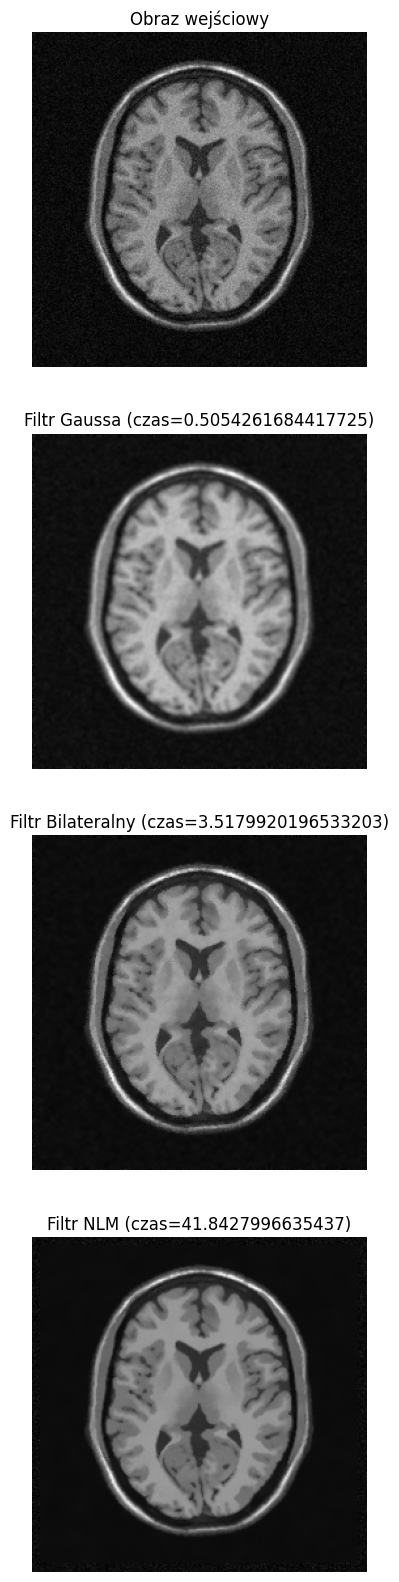

In [ ]:
plt.figure(figsize=(20,20))

plt.subplot(4,1,1)
plt.imshow(I1,'gray')
plt.title('Obraz wejściowy')
plt.axis('off')

plt.subplot(4,1,2)
plt.imshow(I_filtered_Gauss,'gray')
plt.title('Filtr Gaussa (czas={})'.format(time_gauss))
plt.axis('off')

plt.subplot(4,1,3)
plt.imshow(I_filtered_Bilateral,'gray')
plt.title('Filtr Bilateralny (czas={})'.format(time_bilateral))
plt.axis('off')

plt.subplot(4,1,4)
plt.imshow(I_filtered_NLM,'gray')
plt.title('Filtr NLM (czas={})'.format(time_NLM))
plt.axis('off')
plt.show()

Tak jak można się było spodziewać filtr NLM (Non-Local Means) najlepiej usunął zakłócenia z obrazu wejściowego. Filtr bilateralny pozostawił małe zakłócenia, jednak nie zaciemniają one całego obrazu. Najmniej skuteczny okazał się filtr Gaussa, który usunął część zakłóceń, ale jednocześnie zmniejszył ostrość obrazu. Filtr NLM osiągnął najlepsze rezultaty kosztem czasu przetwarzania. Operacja filtracji zajęła aż   42.7 sekundy, podczas gdy filtr bilateralny wykonał to w 3.6 sekundy.